# Module 3 Project - London Air Quality analysis

1. [Introduction](#intro)
2. [Exploratory Data Analysis](#EDA)
3. [Cleaning](#Cleaning)
4. [Statistical Analysis](#stats)
5. [Discussion](#disc)



<a id='intro'></a>

1. Introduction

    - background about project
    - motivation
    - hypotheses

In [7]:
import pandas as pd
import numpy as np
import statsmodels.stats as sms
from functions import APICaller
import seaborn as sns
import matplotlib.pyplot as plt
import requests as req
import time
import scipy.stats as stats
sns.set_style('darkgrid')

In [8]:
# first testing of data retrieval from 1st API
location1 = 'LH0'
date = '2008-06-01'
url_extension = '/Daily/MonitoringIndex/SiteCode='
openaq_caller = APICaller(base_url='http://api.erg.kcl.ac.uk/AirQuality', ignore_token=True)

test_resp = openaq_caller.retrieve_one(url_extension,location=location1, date=date)

test_resp

{'DailyAirQualityIndex': {'@MonitoringIndexDate': '2008-06-01',
  '@TimeToLive': '59',
  'LocalAuthority': {'@LocalAuthorityCode': '17',
   '@LocalAuthorityName': 'Hillingdon',
   '@LaCentreLatitude': '51.533411',
   '@LaCentreLongitude': '-0.452568',
   '@LaCentreLatitudeWGS84': '6716195.906043',
   '@LaCentreLongitudeWGS84': '-50379.639309',
   'Site': {'@BulletinDate': '2008-06-01 00:00:00',
    '@SiteCode': 'LH0',
    '@SiteName': 'Hillingdon - Harlington',
    '@SiteType': 'Urban Background',
    '@Latitude': '51.48878',
    '@Longitude': '-0.441627',
    '@LatitudeWGS84': '6708212.94408',
    '@LongitudeWGS84': '-49161.6927606',
    'Species': [{'@SpeciesCode': 'NO2',
      '@SpeciesDescription': 'Nitrogen Dioxide',
      '@AirQualityIndex': '1',
      '@AirQualityBand': 'Low',
      '@IndexSource': 'Measurement'},
     {'@SpeciesCode': 'O3',
      '@SpeciesDescription': 'Ozone',
      '@AirQualityIndex': '3',
      '@AirQualityBand': 'Low',
      '@IndexSource': 'Measurement'}]}

In [100]:
#  retrieve name of species (pollutants);
url_for_species = '/Information/Species/Json'
# species_list = openaq_caller.retrieve_one(url_extension=url_for_species)
#  http://api.erg.kcl.ac.uk/AirQuality/Information/Species/Json
base_url='http://api.erg.kcl.ac.uk/AirQuality'
def retrieve_one(main_url,url_extension,location=None, date=None, date1=None):  
        if date1!=None:
            response = req.get(main_url+url_extension+f'{location}/StartDate={date}/EndDate={date1}/Json').json()
        elif (date!=None and date1==None):
            response = req.get(main_url+url_extension+f'{location}/Date={date}/Json').json()
        else:
            print(base_url+url_extension)
            response = req.get(main_url+url_extension).json()
        return response
    
    
retrieve_one(main_url=base_url, url_extension=url_for_species)

http://api.erg.kcl.ac.uk/AirQuality/Information/Species/Json


{'AirQualitySpecies': {'Species': [{'@SpeciesCode': 'CO',
    '@SpeciesName': 'Carbon Monoxide',
    '@Description': "Carbon Monoxide is a colourless, odourless poisonous gas produced by incomplete, or inefficient, combustion of fuel including 'cold' or badly tuned engines.",
    '@HealthEffect': 'The gas affects the transport of oxygen around the body by the blood. At very high levels, this can lead to a significant reduction in the supply of oxygen to the heart, particularly in people suffering from heart disease.',
    '@Link': 'http://www.londonair.org.uk/LondonAir/guide/WhatIsCO.aspx'},
   {'@SpeciesCode': 'NO2',
    '@SpeciesName': 'Nitrogen Dioxide',
    '@Description': 'Nitrogen oxides are formed during high temperature combustion processes from the oxidation of nitrogen in the air or fuel.',
    '@HealthEffect': 'Nitrogen Dioxide has several health impacts and includes general irritation to the eyes, irritation of the respiratory system and shortness of breath.',
    '@Link': 

In [101]:
url_for_sites = '/MonitoringIndex/GroupName={GroupName}/Json'
url_for_daily_1_date = '/Daily/MonitoringIndex/GroupName={GroupName}/Date=2018/06/03/Json'
# retrieve_one(main_url=base_url, url_extension=url_for_daily_1_date, )

print(req.get(base_url + url_for_sites))

<Response [404]>


In [102]:
def retrieve_many(main_url,url_ext,location_list,species, start_date_list, end_date_list):
        data = []
        counter=0
        for i in range(len(start_date_list)):
            for location in location_list:
                response = req.get(f'{main_url}{url_ext}/SiteCode={location}/SpeciesCode={species}/StartDate={start_date_list[i]}/EndDate={end_date_list[i]}/Json').json()
                data.append(response)
                counter+=1
            data_df = pd.read_json(data)    
            return data_df
    


In [103]:
response = req.get('http://api.erg.kcl.ac.uk/AirQuality/Data/SiteSpecies/SiteCode=CT3/SpeciesCode=NO2/StartDate=2006/05/01/EndDate=2006/05/02/csv')

print(response)

<Response [404]>


In [104]:
# will set loop to run over multiple dates
base_url='http://api.erg.kcl.ac.uk/AirQuality'
location_list0 = ['LH0','ZR2', 'BL0', 'EN4', 'CT3', 'RI1']
species_code='NO2'
url_data = '/Data/SiteSpecies'
start_dates = ['2006/05/01', '2006/10/01']
end_dates = ['2006/06/01', '2006/11/01']

NO2_LEZ = retrieve_many(main_url=base_url, url_ext = url_data, location_list=location_list0, species=species_code, start_date_list = start_dates, end_date_list = end_dates)

JSONDecodeError: Unexpected UTF-8 BOM (decode using utf-8-sig): line 1 column 1 (char 0)

In [ ]:
# API failed to work after many attempts. Might go back to this. Will just use CSV downloaded data for now. 

### Data cleaning

We've downloaded and have processed our data. We've initially selected data for six sites across Inner London for the LEZ testing (hypotheses 2 and 4). 

In [9]:
df_no2 = pd.read_csv('city_no2.csv')
print(df_no2.shape)
df_no2.head()

(25260, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,NO2,01/01/2006 00:00,37.4,ug m-3,R
1,CT3,NO2,02/01/2006 00:00,39.8,ug m-3,R
2,CT3,NO2,03/01/2006 00:00,57.5,ug m-3,R
3,CT3,NO2,04/01/2006 00:00,51.0,ug m-3,R
4,CT3,NO2,05/01/2006 00:00,50.7,ug m-3,R


In [10]:
import data_cleaning

IndentationError: expected an indented block (data_cleaning.py, line 28)

In [11]:
df_no2.describe()

,Value
count,20967.000000
mean,64.836586
std,38.581488
min,2.800000
25%,37.600000
50%,56.000000
75%,80.900000
max,289.600010


In [12]:
df_no2.Site.value_counts(dropna=False)

CT6    5052
WM6    5052
KC1    5052
CT3    5052
HK6    5052
Name: Site, dtype: int64

In [13]:
# convert strings to datetime objects

df_no2.ReadingDateTime = pd.to_datetime(df_no2.ReadingDateTime)
df_no2.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,NO2,2006-01-01,37.4,ug m-3,R
1,CT3,NO2,2006-02-01,39.8,ug m-3,R
2,CT3,NO2,2006-03-01,57.5,ug m-3,R
3,CT3,NO2,2006-04-01,51.0,ug m-3,R
4,CT3,NO2,2006-05-01,50.7,ug m-3,R


In [14]:
# check number of missing values

df_no2.isna().sum()

Site                          0
Species                       0
ReadingDateTime               0
Value                      4293
Units                         0
Provisional or Ratified       0
dtype: int64

In [15]:
df_no2.loc[(df_no2).Value.isnull()].head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
46,CT3,NO2,2006-02-16,NaN,ug m-3,R
47,CT3,NO2,2006-02-17,NaN,ug m-3,R
204,CT3,NO2,2006-07-24,NaN,ug m-3,R
205,CT3,NO2,2006-07-25,NaN,ug m-3,R
206,CT3,NO2,2006-07-26,NaN,ug m-3,R


In [16]:
# delete the rows with Nan value for the df_no2 DataFrame

df_no2.dropna(inplace=True)
print(df_no2.shape)
df_no2.tail()

(20967, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
25255,WM6,NO2,2019-10-27,53.3,ug m-3,P
25256,WM6,NO2,2019-10-28,47.5,ug m-3,P
25257,WM6,NO2,2019-10-29,48.7,ug m-3,P
25258,WM6,NO2,2019-10-30,60.3,ug m-3,P
25259,WM6,NO2,2019-10-31,59.4,ug m-3,P


In [17]:
# create year column

df_no2['Year'] = df_no2.ReadingDateTime.dt.year
df_no2.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year
0,CT3,NO2,2006-01-01,37.4,ug m-3,R,2006
1,CT3,NO2,2006-02-01,39.8,ug m-3,R,2006
2,CT3,NO2,2006-03-01,57.5,ug m-3,R,2006
3,CT3,NO2,2006-04-01,51.0,ug m-3,R,2006
4,CT3,NO2,2006-05-01,50.7,ug m-3,R,2006


In [18]:
df_no2['Provisional or Ratified'].value_counts()

R    19635
P     1332
Name: Provisional or Ratified, dtype: int64

In [19]:
# create new dataframe with only the value and year columns

df_no2_new = df_no2.drop(['Site','Species','ReadingDateTime','Units','Provisional or Ratified'],axis=1)
df_no2_new.head()

,Value,Year
0,37.4,2006
1,39.8,2006
2,57.5,2006
3,51.0,2006
4,50.7,2006


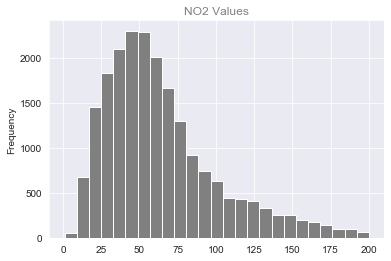

In [20]:
# make a frequency barplot

df_no2.Value.plot.hist(range=(1, 200), bins=25, color='grey')
plt.title('NO2 Values', color = 'grey')
plt.show()

In [21]:
# create PM10 particulates DataFrame

df_pm10 = pd.read_csv('city_pm10.csv')
print(df_pm10.shape)
df_pm10.head()

(25260, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,PM10,01/01/2006 00:00,7.0,ug/m3,R
1,CT3,PM10,02/01/2006 00:00,14.0,ug/m3,R
2,CT3,PM10,03/01/2006 00:00,19.0,ug/m3,R
3,CT3,PM10,04/01/2006 00:00,18.0,ug/m3,R
4,CT3,PM10,05/01/2006 00:00,20.0,ug/m3,R


In [22]:
# check number of sites 

df_pm10.Site.value_counts(dropna=False)

CT8    5052
WM6    5052
MY7    5052
CT3    5052
HK6    5052
Name: Site, dtype: int64

In [23]:
len(df_pm10)

25260

In [24]:
df_pm10.loc[df_pm10.Value.isna()]
# given that we have ~4600 NaN values amongst nearly 30k values, we can drop them

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
46,CT3,PM10,16/02/2006 00:00,NaN,ug/m3,R
47,CT3,PM10,17/02/2006 00:00,NaN,ug/m3,R
48,CT3,PM10,18/02/2006 00:00,NaN,ug/m3,R
49,CT3,PM10,19/02/2006 00:00,NaN,ug/m3,R
50,CT3,PM10,20/02/2006 00:00,NaN,ug/m3,R
...,...,...,...,...,...,...
25171,WM6,PM10,04/08/2019 00:00,NaN,ug/m3,P
25172,WM6,PM10,05/08/2019 00:00,NaN,ug/m3,P
25232,WM6,PM10,04/10/2019 00:00,NaN,ug/m3,P
25233,WM6,PM10,05/10/2019 00:00,NaN,ug/m3,P


In [25]:
df_pm10.Value = df_pm10.Value.dropna()

In [26]:
df_pm10.loc[df_pm10.Value.isna()]


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
46,CT3,PM10,16/02/2006 00:00,NaN,ug/m3,R
47,CT3,PM10,17/02/2006 00:00,NaN,ug/m3,R
48,CT3,PM10,18/02/2006 00:00,NaN,ug/m3,R
49,CT3,PM10,19/02/2006 00:00,NaN,ug/m3,R
50,CT3,PM10,20/02/2006 00:00,NaN,ug/m3,R
...,...,...,...,...,...,...
25171,WM6,PM10,04/08/2019 00:00,NaN,ug/m3,P
25172,WM6,PM10,05/08/2019 00:00,NaN,ug/m3,P
25232,WM6,PM10,04/10/2019 00:00,NaN,ug/m3,P
25233,WM6,PM10,05/10/2019 00:00,NaN,ug/m3,P


In [39]:
df_pm10 = df_pm10.loc[df_pm10.Value.isna()==False]


In [40]:
df_pm10.head(20)

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,PM10,01/01/2006 00:00,7.0,ug/m3,R
1,CT3,PM10,02/01/2006 00:00,14.0,ug/m3,R
2,CT3,PM10,03/01/2006 00:00,19.0,ug/m3,R
3,CT3,PM10,04/01/2006 00:00,18.0,ug/m3,R
4,CT3,PM10,05/01/2006 00:00,20.0,ug/m3,R
5,CT3,PM10,06/01/2006 00:00,28.0,ug/m3,R
6,CT3,PM10,07/01/2006 00:00,33.0,ug/m3,R
7,CT3,PM10,08/01/2006 00:00,34.0,ug/m3,R
8,CT3,PM10,09/01/2006 00:00,36.0,ug/m3,R
9,CT3,PM10,10/01/2006 00:00,21.0,ug/m3,R


In [41]:
df_pm10.ReadingDateTime = pd.to_datetime(df_pm10.ReadingDateTime)
df_pm10.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,PM10,2006-01-01,7.0,ug/m3,R
1,CT3,PM10,2006-02-01,14.0,ug/m3,R
2,CT3,PM10,2006-03-01,19.0,ug/m3,R
3,CT3,PM10,2006-04-01,18.0,ug/m3,R
4,CT3,PM10,2006-05-01,20.0,ug/m3,R


In [42]:
df_pm10['Year'] = df_pm10.ReadingDateTime.dt.year
df_pm10.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year
0,CT3,PM10,2006-01-01,7.0,ug/m3,R,2006
1,CT3,PM10,2006-02-01,14.0,ug/m3,R,2006
2,CT3,PM10,2006-03-01,19.0,ug/m3,R,2006
3,CT3,PM10,2006-04-01,18.0,ug/m3,R,2006
4,CT3,PM10,2006-05-01,20.0,ug/m3,R,2006


In [43]:
# create new dataframe with only the value and year columns

df_pm10_new = df_pm10.drop(['Site','Species','ReadingDateTime','Units','Provisional or Ratified'],axis=1)
df_pm10_new.head()

,Value,Year
0,7.0,2006
1,14.0,2006
2,19.0,2006
3,18.0,2006
4,20.0,2006


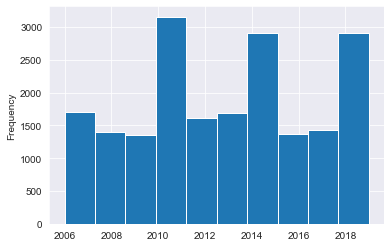

In [44]:
df_pm10_new['Year'].plot.hist()
# given that the data across time is non-uniform, for unknown reasons, we'll be trying to select pre- and post-ULEZ 
# data from 2006,2010,2014 and 2018

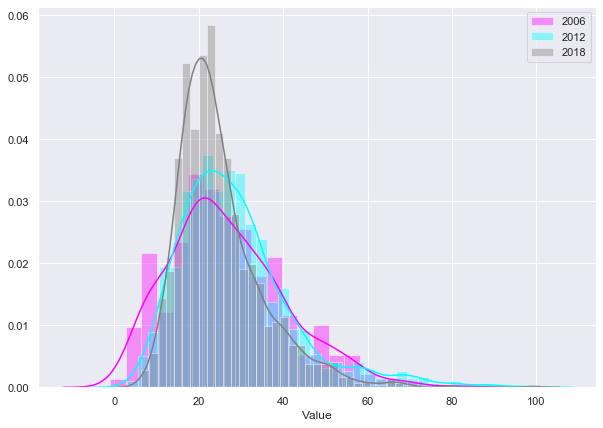

In [45]:
sns.set_color_codes('dark')
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2006]['Value'], color='magenta')
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2012]['Value'], color='cyan')
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2018]['Value'], color='grey')
plt.legend(labels=['2006', '2012', '2018'])

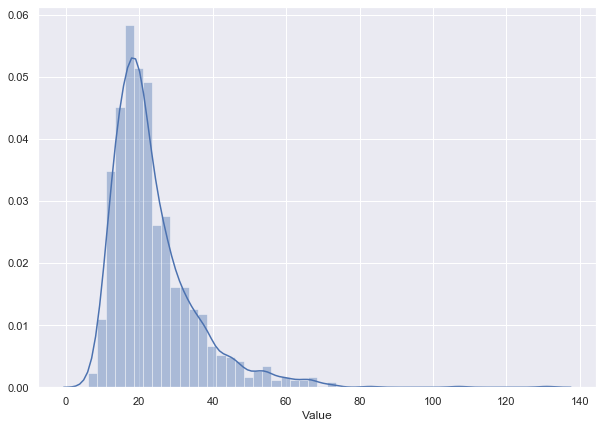

In [46]:
sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2019]['Value'])

In [47]:
df_pm10.head(20)

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year
0,CT3,PM10,2006-01-01,7.0,ug/m3,R,2006
1,CT3,PM10,2006-02-01,14.0,ug/m3,R,2006
2,CT3,PM10,2006-03-01,19.0,ug/m3,R,2006
3,CT3,PM10,2006-04-01,18.0,ug/m3,R,2006
4,CT3,PM10,2006-05-01,20.0,ug/m3,R,2006
5,CT3,PM10,2006-06-01,28.0,ug/m3,R,2006
6,CT3,PM10,2006-07-01,33.0,ug/m3,R,2006
7,CT3,PM10,2006-08-01,34.0,ug/m3,R,2006
8,CT3,PM10,2006-09-01,36.0,ug/m3,R,2006
9,CT3,PM10,2006-10-01,21.0,ug/m3,R,2006


In [48]:
df_pm10['Month'] = df_pm10.ReadingDateTime.dt.month
df_pm10

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year,Month
0,CT3,PM10,2006-01-01,7.0,ug/m3,R,2006,1
1,CT3,PM10,2006-02-01,14.0,ug/m3,R,2006,2
2,CT3,PM10,2006-03-01,19.0,ug/m3,R,2006,3
3,CT3,PM10,2006-04-01,18.0,ug/m3,R,2006,4
4,CT3,PM10,2006-05-01,20.0,ug/m3,R,2006,5
...,...,...,...,...,...,...,...,...
25255,WM6,PM10,2019-10-27,20.0,ug/m3,P,2019,10
25256,WM6,PM10,2019-10-28,27.0,ug/m3,P,2019,10
25257,WM6,PM10,2019-10-29,18.0,ug/m3,P,2019,10
25258,WM6,PM10,2019-10-30,30.0,ug/m3,P,2019,10


In [49]:
df_no2['Month'] = df_no2.ReadingDateTime.dt.month
df_no2

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified,Year,Month
0,CT3,NO2,2006-01-01,37.4,ug m-3,R,2006,1
1,CT3,NO2,2006-02-01,39.8,ug m-3,R,2006,2
2,CT3,NO2,2006-03-01,57.5,ug m-3,R,2006,3
3,CT3,NO2,2006-04-01,51.0,ug m-3,R,2006,4
4,CT3,NO2,2006-05-01,50.7,ug m-3,R,2006,5
...,...,...,...,...,...,...,...,...
25255,WM6,NO2,2019-10-27,53.3,ug m-3,P,2019,10
25256,WM6,NO2,2019-10-28,47.5,ug m-3,P,2019,10
25257,WM6,NO2,2019-10-29,48.7,ug m-3,P,2019,10
25258,WM6,NO2,2019-10-30,60.3,ug m-3,P,2019,10


In [69]:
# For our comparison groups we will be selecting Sites, Species, Value, Units, Year and Month for May and Oct 2006 & 2009
test_df_no2 = df_no2.loc[(df_no2.Month == 5)|(df_no2.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])
test_df_pm10 = df_pm10.loc[(df_pm10.Month == 5)|(df_pm10.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])

test_df_no2.head()

,Site,Species,Value,Units,Year,Month
4,CT3,NO2,50.7,ug m-3,2006,5
9,CT3,NO2,31.0,ug m-3,2006,10
35,CT3,NO2,71.1,ug m-3,2006,5
40,CT3,NO2,71.1,ug m-3,2006,10
63,CT3,NO2,68.0,ug m-3,2006,5


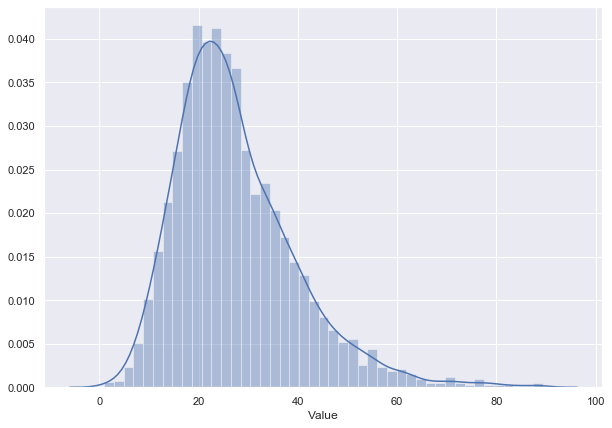

In [70]:
sns.distplot(test_df_pm10.Value)

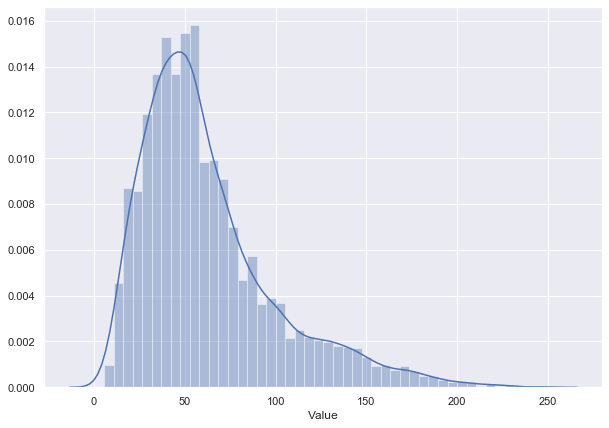

In [71]:
sns.distplot(test_df_no2.Value)

In [72]:
len(test_df_pm10)

3332

In [73]:
len(test_df_no2)

3560

In [74]:
len(test_df_no2.loc[test_df_no2['Year']==2006])

160

In [75]:
len(test_df_no2.loc[test_df_no2['Year']==2009])

241

In [63]:
# Now we make our testing samples below, for May and Oct 2006, 2009, for both the PM10 and the NO2 values. 
pre_lez_no2 = test_df_no2.loc[test_df_no2['Year']==2006]
post_lez_no2 = test_df_no2.loc[test_df_no2['Year']==2009]

pre_lez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2006]
post_lez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2009]

In [76]:
pre_ulez_no2 = test_df_no2.loc[test_df_no2['Year']==2017]
post_ulez_no2 = test_df_no2.loc[test_df_no2['Year']==2019]

pre_ulez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2017]
post_ulez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2019]

In [77]:
pre_lez_no2.Site.value_counts()

KC1    62
CT3    59
HK6    39
Name: Site, dtype: int64

In [78]:
pre_lez_pm10.Site.value_counts()

HK6    61
CT3    56
MY7    29
Name: Site, dtype: int64

## Statistical Testing

(Mina)

1. The introducton of ULEZ (8th April 2019) decreased the amount of NOx in Zone 1 of Central London by at least 42%. 
[H0] - ULEZ reduced the amount of NOx in Zone 1 by less than 42%.
2. The introduction of ULEZ was at least 25% more effective than the introduction of LEZ (4th February 2008) in reducing NOx levels in Central London.
[H0] - The effect of ULEZ on NOx levels was less than 25% more than the impact of LEZ. 

(Ioana) 
3. The introducton of ULEZ decreased the amount of PM10 in Zone 1 of Central London by at least 33%. 
[H0] - ULEZ reduced the amount of PM10 in Zone 1 by less than 33%.
4. The introduction of ULEZ was at least 25% more effective than the introduction of LEZ in reducing PM10 levels in Central London. 
[H0] - The effect of ULEZ on PM10 levels was less than 25% more than the impact of LEZ. 

Our alpha values are set at 0.05.

In [37]:
def sample_variance(sample):
    return np.sum([(x - np.mean(sample))**2 for x in sample])/(len(sample)-1)

def pooled_variance(sample1, sample2):
    return ((len(sample1)-1)*sample_variance(sample1) + (len(sample2)-1)*sample_variance(sample2))/(len(sample1) + len(sample2) - 2)


def visualize_t(t_stat, n_control, n_experimental):
    df = len(n_experimental)-1
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4,4,200)
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    ys = stats.t.pdf(xs, df, 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkblue')

    # Draw two sided boundary for critical-t
    ax.axvline(x=+t_stat, color='red', linestyle='--', lw=3,label='t-statistic_lower_bound')
    ax.axvline(x=-t_stat, color='purple', linestyle='--', lw=3,label='t-statistic_upper_bound')
    ax.legend()
    plt.show()
    return 

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    # Calculate the pooled threshold as shown earlier
    pooled_var = pooled_variance(group1, group2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d


def welch_t_test(sample1,sample2):
    num = np.mean(sample1)-np.mean(sample2)
    denom = np.sqrt((sample_variance(sample1)**2/len(sample1)) + (sample_variance(sample2)**2/len(sample2)))
    return num/denom
 

    
    
              
def p_val(t_stat, df):
    return 1-stats.t.cdf(t_stat,df)

In [36]:
p_val(welch_t(pre_lez_no2.Value, post_lez_no2.Value), welch_dof(pre_lez_no2.Value, post_lez_no2.Value))

NameError: name 'p_val' is not defined

In [174]:
p_val(welch_t(pre_lez_pm10.Value, post_lez_pm10.Value), welch_dof(pre_lez_pm10.Value, post_lez_pm10.Value))

0.001084656181371657

In [179]:
stats.ttest_ind(pre_lez_no2.Value, post_lez_no2.Value, equal_var=False)

Ttest_indResult(statistic=-8.012063019754985, pvalue=1.6679765872394386e-14)

In [180]:
stats.ttest_ind(pre_lez_pm10.Value, post_lez_pm10.Value, equal_var=False)

Ttest_indResult(statistic=-3.085567543887115, pvalue=0.0022366123527511423)

In [182]:
lez_d_no2 = Cohen_d(pre_lez_no2.Value, post_lez_no2.Value)
print("The effect of LEZ on the levels of NO2 in the Central London: ", lez_d_no2)

The effect of LEZ on the levels of NO2 in the Central London:  -0.7107865332000353


In [183]:
lez_d_pm10 = Cohen_d(pre_lez_pm10.Value, post_lez_pm10.Value)
print("The effect of LEZ on the levels of PM10 in the Central London: ", lez_d_pm10)

The effect of LEZ on the levels of PM10 in the Central London:  -0.33689341622282065


Having conducted our statistical significance test for LEZ, we conclude that there was a significant impact on NO2 levels due to LEZ, but our p-value for the PM10 levels was so large that we cannot reject the null hypothesis that LEZ had no impact on PM10. Given that we're trying to compare ULEZ to LEZ impact, we will return to the PM10 levels once we have conducted our tests on the ULEZ dates

In [79]:
len(pre_lez_no2)

160

In [80]:
len(post_ulez_no2)

280

In [81]:
len(pre_ulez_pm10)

245

In [82]:
len(post_ulez_pm10)

261

In [83]:
pre_ulez_no2.Site.value_counts()

WM6    62
HK6    62
KC1    62
CT6    61
CT3    60
Name: Site, dtype: int64

For our pre- and post-ULEZ comparisons we'll be using a different batch of data. 

In [85]:
city_df_pm10 = pd.read_csv('city_pm10.csv')
city_df_no2 = pd.read_csv('city_no2.csv')

In [86]:
city_df_pm10.Site.value_counts()

CT8    5052
WM6    5052
MY7    5052
CT3    5052
HK6    5052
Name: Site, dtype: int64

In [87]:
city_df_no2.Site.value_counts()

CT6    5052
WM6    5052
KC1    5052
CT3    5052
HK6    5052
Name: Site, dtype: int64

In [88]:
# cleaning the data as before
city_df_pm10.tail()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
25255,WM6,PM10,27/10/2019 00:00,20.0,ug/m3,P
25256,WM6,PM10,28/10/2019 00:00,27.0,ug/m3,P
25257,WM6,PM10,29/10/2019 00:00,18.0,ug/m3,P
25258,WM6,PM10,30/10/2019 00:00,30.0,ug/m3,P
25259,WM6,PM10,31/10/2019 00:00,41.0,ug/m3,P


In [89]:
len(city_df_pm10)

25260

In [90]:
len(city_df_no2)

25260

In [91]:
print(len(city_df_pm10.loc[city_df_pm10.Value.isna()]))
print(len(city_df_no2.loc[city_df_no2.Value.isna()]))

5721
4293


In [92]:
city_df_pm10 = city_df_pm10.dropna()
city_df_no2 = city_df_no2.dropna()

# city_df_pm10 = city_df_pm10.

city_df_pm10.ReadingDateTime = pd.to_datetime(city_df_pm10.ReadingDateTime)
city_df_no2.ReadingDateTime = pd.to_datetime(city_df_no2.ReadingDateTime)

city_df_pm10['Year'] = city_df_pm10.ReadingDateTime.dt.year
city_df_no2['Year'] = city_df_no2.ReadingDateTime.dt.year

city_df_pm10['Month'] = city_df_pm10.ReadingDateTime.dt.month
city_df_no2['Month'] = city_df_no2.ReadingDateTime.dt.month


In [93]:
ulez_test_df_no2 = city_df_no2.loc[(city_df_no2.Month == 5)|(city_df_no2.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])
ulez_test_df_pm10 = city_df_pm10.loc[(city_df_pm10.Month == 5)|(city_df_pm10.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])

ulez_test_df_no2.tail()

,Site,Species,Value,Units,Year,Month
25255,WM6,NO2,53.3,ug m-3,2019,10
25256,WM6,NO2,47.5,ug m-3,2019,10
25257,WM6,NO2,48.7,ug m-3,2019,10
25258,WM6,NO2,60.3,ug m-3,2019,10
25259,WM6,NO2,59.4,ug m-3,2019,10


In [94]:
pre_ulez_no2 = ulez_test_df_no2.loc[ulez_test_df_no2['Year']==2018]
post_ulez_no2 = ulez_test_df_no2.loc[ulez_test_df_no2['Year']==2019]

pre_ulez_pm10 = ulez_test_df_pm10.loc[ulez_test_df_pm10['Year']==2018]
post_ulez_pm10 = ulez_test_df_pm10.loc[ulez_test_df_pm10['Year']==2019]

In [95]:
stats.ttest_ind(pre_ulez_no2.Value, post_ulez_no2.Value, equal_var=False)

Ttest_indResult(statistic=4.049535449640252, pvalue=5.839985706019674e-05)

In [96]:
stats.ttest_ind(pre_ulez_pm10.Value, post_ulez_pm10.Value, equal_var=False)

Ttest_indResult(statistic=7.387635966553068, pvalue=7.689918805869116e-13)

In [130]:
ulez_d_no2 = Cohen_d(post_ulez_no2.Value, pre_ulez_no2.Value)
print("The effect of ULEZ on the levels of NO2 in the City of London: ", ulez_d_no2)

The effect of ULEZ on the levels of NO2 in the City of London:  -0.3349861633156012


In [131]:
ulez_d_pm10 = Cohen_d(post_ulez_pm10.Value, pre_ulez_pm10.Value)
print("The effect of ULEZ on the levels of PM10 in the City of London: ", ulez_d_pm10)

The effect of ULEZ on the levels of PM10 in the City of London:  -0.6590225517547698


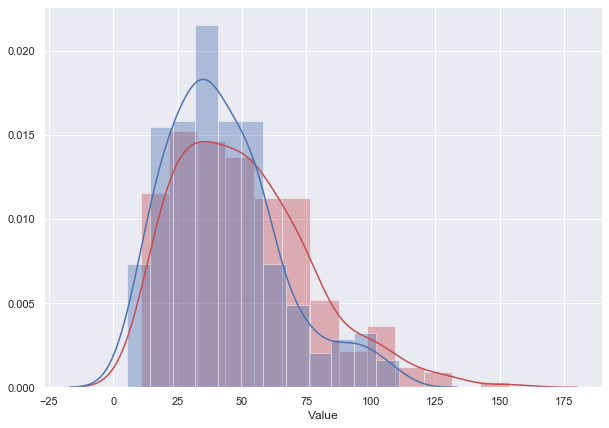

In [97]:
sns.distplot(pre_ulez_no2.Value,color='r')
sns.distplot(post_ulez_no2.Value,color='b')

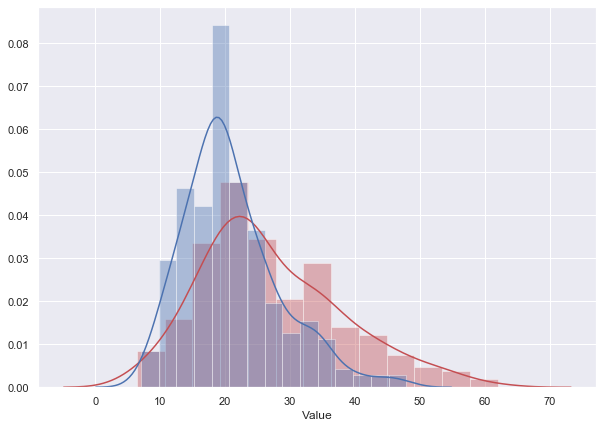

In [98]:
sns.distplot(pre_ulez_pm10.Value,color='r')
sns.distplot(post_ulez_pm10.Value,color='b')

In [190]:
# Testing hypothesis nr 2:
print('The impact of ULEZ on NO2 was ', round((ulez_d_no2/lez_d_no2)*100,1),'% more significant than LEZ.')

The impact of ULEZ on NO2 was  47.1 % more significant than LEZ.


In [191]:
# Testing hypothesis nr 4:
print('The impact of ULEZ on PM10 was ', round((ulez_d_pm10/lez_d_pm10)*100,1),'% more significant than LEZ.')

The impact of ULEZ on PM10 was  195.6 % more significant than LEZ.


Checkpoint: at the moment, given the data that we have used, we have managed to reject all four null hypotheses and go and to test the alternative hypotheses. 
HOWEVER, we have realized now that our data is not adequate for the Welch's T-test, so we will be re-running our sampling to achieve a more normal distribution.

In [192]:
print(lez_d_no2)

-0.7107865332000353


In [195]:
print((post_lez_no2.Value.mean()-pre_lez_no2.Value.mean())/ pre_lez_no2.Value.mean())

0.5348771591839976


In [196]:
print((post_lez_pm10.Value.mean()-pre_lez_pm10.Value.mean())/ pre_lez_pm10.Value.mean())

0.1787045811661949


In [197]:
print((post_ulez_no2.Value.mean()-pre_ulez_no2.Value.mean())/ pre_ulez_no2.Value.mean())

-0.16088582573534785


In [198]:
print((post_ulez_pm10.Value.mean()-pre_ulez_pm10.Value.mean())/ pre_ulez_pm10.Value.mean())

-0.22714602333501452


In [199]:
len(post_ulez_no2.Value)

280

In [243]:
pre_ulez_no2.head()

,Site,Species,Value,Units,Year,Month
4387,CT3,NO2,45.3,ug m-3,2018,5
4392,CT3,NO2,56.5,ug m-3,2018,10
4418,CT3,NO2,24.5,ug m-3,2018,5
4423,CT3,NO2,32.2,ug m-3,2018,10
4446,CT3,NO2,35.3,ug m-3,2018,5


In [244]:
post_ulez_no2.head()

,Site,Species,Value,Units,Year,Month
4783,CT3,NO2,37.1,ug m-3,2019,5
4788,CT3,NO2,27.8,ug m-3,2019,10
4811,CT3,NO2,37.5,ug m-3,2019,5
4816,CT3,NO2,27.7,ug m-3,2019,10
4842,CT3,NO2,38.1,ug m-3,2019,5


In [99]:
import hypothesis_tests as hyp
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
pre_ulez_no2 = pre_ulez_no2.loc[pre_ulez_no2.Month == 5]
post_ulez_no2 = post_ulez_no2.loc[post_ulez_no2.Month == 5]


In [101]:
len(pre_ulez_no2)

149

In [102]:
len(post_ulez_no2)

141

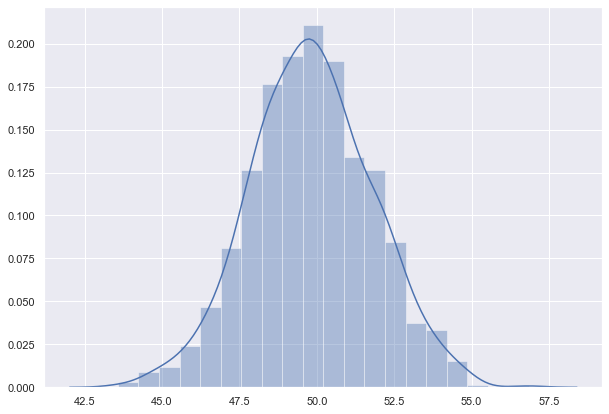

In [126]:
sns.distplot(hyp.create_sample_dists(pre_ulez_no2, 'Value', 1000, 200),bins=20)

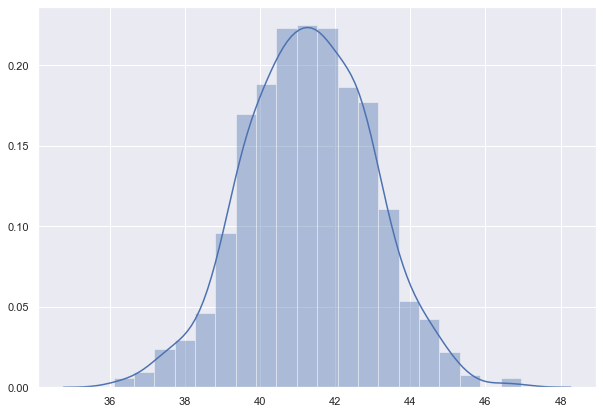

In [127]:
sns.distplot(hyp.create_sample_dists(post_ulez_no2, 'Value', 1000, 200), bins=20)

In [106]:
pre_ulez_test_code = hyp.create_sample_dists(pre_ulez_no2, 'Value', 100, 50)
post_ulez_test_code = hyp.create_sample_dists(post_ulez_no2, 'Value', 100, 50)

w = hyp.welch_t(post_ulez_test_code, pre_ulez_test_code)
dof = hyp.welch_dof(post_ulez_test_code, pre_ulez_test_code)

p_value = hyp.p_val(w, dof)
pool_var = hyp.pool_var(post_ulez_test_code, pre_ulez_test_code)
coh_d = hyp.Cohen_d(post_ulez_test_code, pre_ulez_test_code)
coh_d

hyp.compare_pval_alpha(p_value, 0.05)


'Reject'

Based on the p value of 0.0 and our alpha of 0.05 we reject  the null hypothesis.
 Due to these results, we  can state that there is a difference between our samples 
with an effect size, Cohen's d, of -3.469 and power of 1.0.


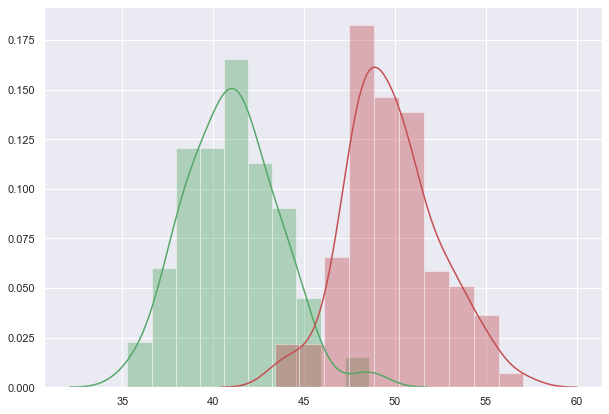

In [132]:
hypothesis_NO2_ULEZ = hyp.hypothesis_test_one(post_ulez_no2, pre_ulez_no2, 'Value', 100, 100, alpha=0.05)

Based on the p value of 0.0 and our alpha of 0.05 we reject  the null hypothesis.
 Due to these results, we  can state that there is a difference between our samples 
with an effect size, Cohen's d, of -6.773 and power of 1.0.


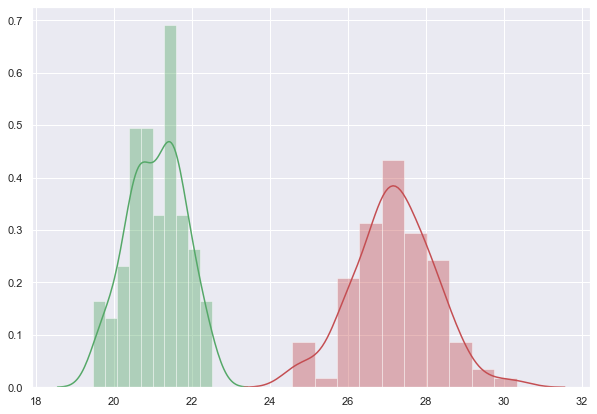

In [133]:
hypotesis_PM10_ULEZ = code_test2 = hyp.hypothesis_test_one(post_ulez_pm10, pre_ulez_pm10, 'Value', 100, 100, alpha=0.05)

Based on the p value of 0.0 and our alpha of 0.05 we reject  the null hypothesis.
 Due to these results, we  can state that there is a difference between our samples 
with an effect size, Cohen's d, of -3.277 and power of 1.0.
Based on the p value of 0.0 and our alpha of 0.05 we reject  the null hypothesis.
 Due to these results, we  can state that there is a difference between our samples 
with an effect size, Cohen's d, of 8.247 and power of 1.0.
Reject 

Reject 



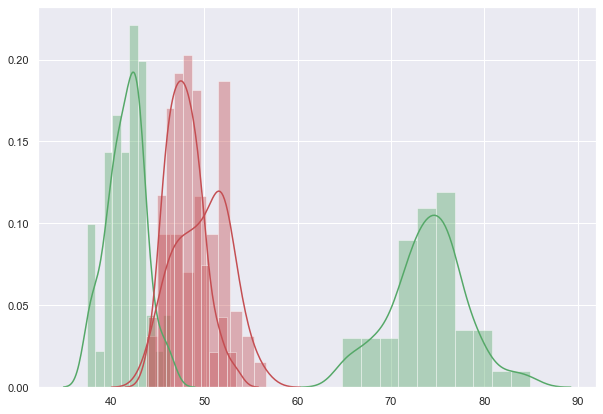

In [134]:

hypothesis_NO2_LEZvsULEZ = hyp.hypothesis_test_two(post_ulez_no2, pre_ulez_no2, 'Value', 100, 100, post_lez_no2, pre_lez_no2, 'NO2',alpha = 0.05)

Based on the p value of 0.0 and our alpha of 0.05 we reject  the null hypothesis.
 Due to these results, we  can state that there is a difference between our samples 
with an effect size, Cohen's d, of -6.368 and power of 1.0.
Based on the p value of 0.0 and our alpha of 0.05 we reject  the null hypothesis.
 Due to these results, we  can state that there is a difference between our samples 
with an effect size, Cohen's d, of 3.804 and power of 1.0.
Reject 

Reject 



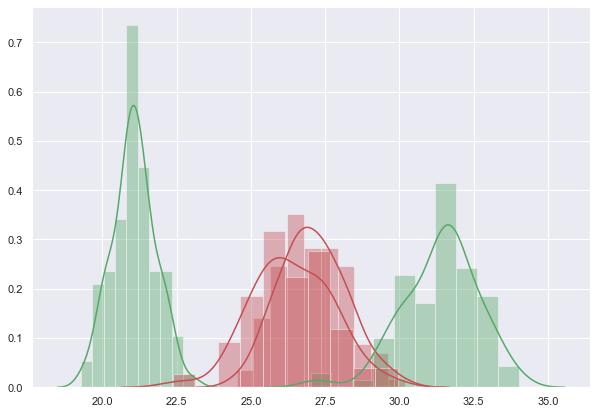

In [135]:
hypothesis_PM10_LEZvsULEZ = hyp.hypothesis_test_two(post_ulez_pm10, pre_ulez_pm10, 'Value', 100, 100, post_lez_pm10, pre_lez_pm10, 'PM10',alpha = 0.05)